In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

from math import radians
from sklearn.metrics.pairwise import haversine_distances

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics


%matplotlib inline

In [4]:
weather_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/weather.csv')
spray_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/spray.csv')
train_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/train.csv')
test_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/test.csv',index_col='Id')

In [5]:
pd.set_option('display.max_columns', None)

# Cleaning and Transforming the Weather Dataframe

In [6]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [7]:
weather_df.replace('M',np.nan,inplace=True)

In [8]:
weather_df[['Year', 'Month', 'Day']] = weather_df['Date'].str.split('-',expand=True)

In [9]:
weather_df['Sunrise'].replace('-',None, inplace=True)
weather_df['Sunset'].replace('-',None, inplace=True)

In [10]:
weather_df['Depart'].fillna(method='ffill',inplace=True)

In [11]:
weather_df['Trange'] = weather_df['Tmax'] - weather_df['Tmin']

In [12]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Trange
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,05,01,33
1,2,2007-05-01,84,52,68,14,51,57,0,3,0448,1849,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,2007,05,01,32
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,05,02,17
3,2,2007-05-02,60,43,52,-3,42,47,13,0,0447,1850,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,2007,05,02,17
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,05,03,20


In [13]:
weather_df['CodeSum'].value_counts().head(30)

                 1609
RA                296
RA BR             238
BR                110
TSRA RA BR         92
BR HZ              81
RA DZ BR           65
TSRA RA            43
HZ                 39
RA BR HZ           38
TSRA               34
RA DZ              22
TSRA BR            21
TS TSRA RA BR      19
RA HZ              16
TS RA              13
TSRA RA BR HZ      12
TS                 10
DZ BR              10
TS TSRA BR         10
DZ BR HZ            9
TS RA BR            8
TSRA BR HZ          8
DZ                  8
RA DZ BR HZ         7
TS TSRA             7
TS TSRA BR HZ       7
TS TSRA RA          7
TS BR               4
TSRA HZ             4
Name: CodeSum, dtype: int64

In [14]:
weather_df['Rain'] = weather_df['CodeSum'].str.contains('RA').astype(int)
weather_df['Mist'] = weather_df['CodeSum'].str.contains('BR').astype(int)
weather_df['TSRA'] = weather_df['CodeSum'].str.contains('TSRA').astype(int)
weather_df['Haze'] = weather_df['CodeSum'].str.contains('HZ').astype(int)
weather_df['Drizzle'] = weather_df['CodeSum'].str.contains('DZ').astype(int)
weather_df['Thunderstorm'] = weather_df['CodeSum'].str.contains('TS').astype(int)
weather_df['Local_TS'] = weather_df['CodeSum'].str.contains('VCTS').astype(int)

In [15]:
weather_df['Depth'].value_counts()

0    1472
Name: Depth, dtype: int64

In [16]:
weather_df.drop(['Depth'],axis=1,inplace=True)

In [17]:
weather_df.SnowFall.fillna(method='ffill',inplace=True)

In [18]:
weather_df.SnowFall.value_counts()

0.0    2918
  T      24
0.1       2
Name: SnowFall, dtype: int64

In [19]:
weather_df.SnowFall =  weather_df.SnowFall.replace('  T',0.05)

In [20]:
weather_df.SnowFall.value_counts()

0.0     2918
0.05      24
0.1        2
Name: SnowFall, dtype: int64

In [21]:
weather_df.Tavg.fillna((weather_df.Tmax+weather_df.Tmin)/2,inplace=True)

In [22]:
weather_df.PrecipTotal =  weather_df.PrecipTotal.replace('  T',0.005)

In [23]:
weather_df.WetBulb = pd.to_numeric(weather_df.WetBulb, errors='coerce')

In [24]:
weather_df.WetBulb.fillna(weather_df.WetBulb.mean(),inplace=True)

In [25]:
weather_df.Heat.fillna(0,inplace=True)

In [26]:
weather_df.Cool.fillna(0,inplace=True)

In [27]:
weather_df.PrecipTotal.fillna(0,inplace=True)

In [28]:
weather_df.StnPressure = pd.to_numeric(weather_df.StnPressure,errors='coerce')
weather_df.StnPressure.fillna(weather_df.StnPressure.mean(),inplace=True)

In [29]:
weather_df.SeaLevel = pd.to_numeric(weather_df.SeaLevel,errors='coerce')
weather_df.SeaLevel.fillna(weather_df.SeaLevel.mean(),inplace=True)

In [30]:
weather_df.AvgSpeed = pd.to_numeric(weather_df.AvgSpeed,errors='coerce')
weather_df.AvgSpeed.fillna(weather_df.AvgSpeed.mean(),inplace=True)

In [31]:
weather_df.drop(['Water1'],axis=1,inplace=True)

In [32]:
weather_df

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS
0,1,2007-05-01,83,50,67,14,51,56.0,0,2,0448,1849,,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,05,01,33,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,14,51,57.0,0,3,0448,1849,,0.0,0.00,29.18,29.82,2.7,25,9.6,2007,05,01,32,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47.0,14,0,0447,1850,BR,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,05,02,17,0,1,0,0,0,0,0
3,2,2007-05-02,60,43,52,-3,42,47.0,13,0,0447,1850,BR HZ,0.0,0.00,29.44,30.08,13.3,2,13.4,2007,05,02,17,0,1,0,1,0,0,0
4,1,2007-05-03,66,46,56,2,40,48.0,9,0,0446,1851,,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,05,03,20,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,-4,34,42.0,20,0,0620,1650,,0.0,0.00,29.42,30.07,8.5,29,9.0,2014,10,29,9,0,0,0,0,0,0,0
2940,1,2014-10-30,51,32,42,-4,34,40.0,23,0,0622,1649,,0.0,0.00,29.34,30.09,5.1,24,5.5,2014,10,30,19,0,0,0,0,0,0,0
2941,2,2014-10-30,53,37,45,-4,35,42.0,20,0,0622,1649,RA,0.0,0.005,29.41,30.10,5.9,23,6.5,2014,10,30,16,1,0,0,0,0,0,0
2942,1,2014-10-31,47,33,40,-6,25,33.0,25,0,0623,1647,RA SN,0.1,0.03,29.49,30.20,22.6,34,22.9,2014,10,31,14,1,0,0,0,0,0,0


In [33]:
weather_df.dtypes

Station           int64
Date             object
Tmax              int64
Tmin              int64
Tavg             object
Depart           object
DewPoint          int64
WetBulb         float64
Heat             object
Cool             object
Sunrise          object
Sunset           object
CodeSum          object
SnowFall         object
PrecipTotal      object
StnPressure     float64
SeaLevel        float64
ResultSpeed     float64
ResultDir         int64
AvgSpeed        float64
Year             object
Month            object
Day              object
Trange            int64
Rain              int64
Mist              int64
TSRA              int64
Haze              int64
Drizzle           int64
Thunderstorm      int64
Local_TS          int64
dtype: object

In [34]:
columns_int = ['Heat','Cool', 'Sunrise','Sunset','Year','Month','Day','Tavg','Depart']
columns_float = ['SnowFall','PrecipTotal']
weather_df[columns_int] = weather_df[columns_int].astype(int)
weather_df[columns_float] = weather_df[columns_float].astype(float)

In [35]:
weather_df = weather_df.drop(['CodeSum'],axis=1)

In [36]:
weather_df_d = weather_df[['Year', 'Month', 'Day', 'Date', 'Station']]

In [37]:
weather_df_l = weather_df.drop(['Year', 'Month', 'Day', 'Date', 'Station'],axis=1)

In [38]:
weather_df_lagged = weather_df_l
trailing_window_size = 10

#Because there is station 1 and station 2 we need to create lag columns that incriment by 2

for window in range(2, trailing_window_size + 1,2):
    shifted = weather_df_l.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in weather_df_l.columns]

    weather_df_lagged = pd.concat((weather_df_lagged, shifted), axis=1)
    
weather_df_lagged = weather_df_lagged.dropna()

In [39]:
weather_df = pd.concat((weather_df_lagged,weather_df_d),axis=1)
weather_df = weather_df.dropna()

In [40]:
weather_df[['Tmax','Tmax_lag2','Tmax_lag4','Date','Station']].head(20)

,Tmax,Tmax_lag2,Tmax_lag4,Date,Station
10,68.0,66.0,66.0,2007-05-06,1
11,68.0,66.0,78.0,2007-05-06,2
12,83.0,68.0,66.0,2007-05-07,1
13,84.0,68.0,66.0,2007-05-07,2
14,82.0,83.0,68.0,2007-05-08,1
15,80.0,84.0,68.0,2007-05-08,2
16,77.0,82.0,83.0,2007-05-09,1
17,76.0,80.0,84.0,2007-05-09,2
18,84.0,77.0,82.0,2007-05-10,1
19,83.0,76.0,80.0,2007-05-10,2


# Cleaning and Transforming Training Data

In [41]:
train_df = pd.get_dummies(train_df, columns=['Species'], drop_first=True)

In [42]:
train_df.head()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,1,0,0,0,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,0,1,0,0,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,1,0,0,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,0,1,0,0,0,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,0,0,1,0,0,0


In [43]:
# https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

In [44]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [45]:
station1_lat, station1_lon = 41.995, -87.933
station2_lat, station2_lon = 41.786, -87.752

In [46]:
distances_km = []
for row in train_df.itertuples(index=False):
   distances_km.append(
       haversine_distance(station1_lat, station1_lon, row.Latitude, row.Longitude)
   )

In [47]:
train_df['DistanceFromStation1'] = distances_km

In [48]:
distances_km = []
for row in train_df.itertuples(index=False):
   distances_km.append(
       haversine_distance(station2_lat, station2_lon, row.Latitude, row.Longitude)
   )

In [49]:
train_df['DistanceFromStation2'] = distances_km

In [50]:
train_df['Station1_closest'] = train_df['DistanceFromStation1'] < train_df['DistanceFromStation2']
train_df['Station2_closest'] = train_df['DistanceFromStation2'] < train_df['DistanceFromStation1']

In [51]:
train_df.head(30)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,DistanceFromStation1,DistanceFromStation2,Station1_closest,Station2_closest
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,0,1,0,0,0,11.80,19.19,True,False
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,1,0,0,0,13.53,23.28,True,False
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,0,1,0,0,0,0,9.24,21.77,True,False
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,0,0,1,0,0,0,9.24,21.77,True,False
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,0,0,1,0,0,0,23.50,16.66,False,True
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,0,0,1,0,0,0,25.77,14.21,False,True
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,0,1,0,0,0,0,27.09,12.12,False,True
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,0,0,1,0,0,0,27.09,12.12,False,True
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,0,0,1,0,0,0,25.46,14.65,False,True


# Merging DataFrames

In [52]:
# find what weather station is closest to the latitude and longitude of train 
# merge weather data on date and closest weather station to train data

In [102]:
df = pd.merge(train_df,weather_df,on='Date')
df = df.drop(['Address','Street', 'Trap','AddressNumberAndStreet'],axis=1)
df.set_index(['Date'],inplace=True)
df.head()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,DistanceFromStation1,DistanceFromStation2,Station1_closest,Station2_closest,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS,Tmax_lag2,Tmin_lag2,Tavg_lag2,Depart_lag2,DewPoint_lag2,WetBulb_lag2,Heat_lag2,Cool_lag2,Sunrise_lag2,Sunset_lag2,SnowFall_lag2,PrecipTotal_lag2,StnPressure_lag2,SeaLevel_lag2,ResultSpeed_lag2,ResultDir_lag2,AvgSpeed_lag2,Trange_lag2,Rain_lag2,Mist_lag2,TSRA_lag2,Haze_lag2,Drizzle_lag2,Thunderstorm_lag2,Local_TS_lag2,Tmax_lag4,Tmin_lag4,Tavg_lag4,Depart_lag4,DewPoint_lag4,WetBulb_lag4,Heat_lag4,Cool_lag4,Sunrise_lag4,Sunset_lag4,SnowFall_lag4,PrecipTotal_lag4,StnPressure_lag4,SeaLevel_lag4,ResultSpeed_lag4,ResultDir_lag4,AvgSpeed_lag4,Trange_lag4,Rain_lag4,Mist_lag4,TSRA_lag4,Haze_lag4,Drizzle_lag4,Thunderstorm_lag4,Local_TS_lag4,Tmax_lag6,Tmin_lag6,Tavg_lag6,Depart_lag6,DewPoint_lag6,WetBulb_lag6,Heat_lag6,Cool_lag6,Sunrise_lag6,Sunset_lag6,SnowFall_lag6,PrecipTotal_lag6,StnPressure_lag6,SeaLevel_lag6,ResultSpeed_lag6,ResultDir_lag6,AvgSpeed_lag6,Trange_lag6,Rain_lag6,Mist_lag6,TSRA_lag6,Haze_lag6,Drizzle_lag6,Thunderstorm_lag6,Local_TS_lag6,Tmax_lag8,Tmin_lag8,Tavg_lag8,Depart_lag8,DewPoint_lag8,WetBulb_lag8,Heat_lag8,Cool_lag8,Sunrise_lag8,Sunset_lag8,SnowFall_lag8,PrecipTotal_lag8,StnPressure_lag8,SeaLevel_lag8,ResultSpeed_lag8,ResultDir_lag8,AvgSpeed_lag8,Trange_lag8,Rain_lag8,Mist_lag8,TSRA_lag8,Haze_lag8,Drizzle_lag8,Thunderstorm_lag8,Local_TS_lag8,Tmax_lag10,Tmin_lag10,Tavg_lag10,Depart_lag10,DewPoint_lag10,WetBulb_lag10,Heat_lag10,Cool_lag10,Sunrise_lag10,Sunset_lag10,SnowFall_lag10,PrecipTotal_lag10,StnPressure_lag10,SeaLevel_lag10,ResultSpeed_lag10,ResultDir_lag10,AvgSpeed_lag10,Trange_lag10,Rain_lag10,Mist_lag10,TSRA_lag10,Haze_lag10,Drizzle_lag10,Thunderstorm_lag10,Local_TS_lag10,Year,Month,Day,Station
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,41,41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5,28.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,79.0,50.0,65.0,2.0,47.0,56.0,0.0,0.0,421.0,1916.0,0.0,0.005,29.43,30.15,4.8,10.0,5.3,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,57.0,66.0,4.0,47.0,56.0,0.0,1.0,422.0,1916.0,0.0,0.04,29.34,30.06,8.9,26.0,9.5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0,57.0,-5.0,55.0,56.0,8.0,0.0,422.0,1915.0,0.0,1.01,29.36,30.11,2.8,17.0,7.2,16.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,70.0,56.0,63.0,1.0,44.0,53.0,2.0,0.0,423.0,1914.0,0.0,0.005,29.51,30.24,4.9,5.0,8.8,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,63.0,76.0,14.0,54.0,63.0,0.0,11.0,424.0,1913.0,0.0,0.020,29.41,30.11,14.9,21.0,17.3,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,29,1
2007-05-29,41,41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False,88.0,65.0,77.0,10.0,59.0,66.0,0.0,12.0,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16.0,7.4,23.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,76.0,54.0,65.0,2.0,49.0,57.0,0.0,0.0,421.0,1916.0,0.0,0.000,29.49,30.14,4.7,8.0,5.2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,59.0,67.0,4.0,49.0,57.0,0.0,2.0,422.0,1916.0,0.0,0.08,29.41,30.05,8.2,24.0,9.2,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,70.0,50.0,60.0,-5.0,55.0,57.0,5.0,0.0,422.0,1915.0,0.0,0.28,29.42,30.10,2.5,15.0,7.8,20.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,66.0,57.0,62.0,1.0,46.0,53.0,3.0,0.0,423.0,1914.0,0.0,0.090,29.57,30.23,4.5,5.0,8.2,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,88.0,66.0,77.0,14.0,53.0,63.0,0.0,12.0,424.0,1913.0,0.0,0.005,29.47,30.10,13.8,20.0,15.2,22.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,29,2
2007-05-29,41,41.954690,-87.800991,9,1,0,0,0,1,0,0,0,11.80,19.19,True,False,88.0,60.0,74.0,10.0,58.0,65.0

In [103]:
df = df[((df['Station1_closest'] == True) & (df['Station'] == 1)) | ((df['Station2_closest'] == True) & (df['Station'] == 2))]

In [104]:
df = df.drop(['DistanceFromStation1','DistanceFromStation2','Station1_closest','Station2_closest','Station'],axis=1)

In [105]:
df.head()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS,Tmax_lag2,Tmin_lag2,Tavg_lag2,Depart_lag2,DewPoint_lag2,WetBulb_lag2,Heat_lag2,Cool_lag2,Sunrise_lag2,Sunset_lag2,SnowFall_lag2,PrecipTotal_lag2,StnPressure_lag2,SeaLevel_lag2,ResultSpeed_lag2,ResultDir_lag2,AvgSpeed_lag2,Trange_lag2,Rain_lag2,Mist_lag2,TSRA_lag2,Haze_lag2,Drizzle_lag2,Thunderstorm_lag2,Local_TS_lag2,Tmax_lag4,Tmin_lag4,Tavg_lag4,Depart_lag4,DewPoint_lag4,WetBulb_lag4,Heat_lag4,Cool_lag4,Sunrise_lag4,Sunset_lag4,SnowFall_lag4,PrecipTotal_lag4,StnPressure_lag4,SeaLevel_lag4,ResultSpeed_lag4,ResultDir_lag4,AvgSpeed_lag4,Trange_lag4,Rain_lag4,Mist_lag4,TSRA_lag4,Haze_lag4,Drizzle_lag4,Thunderstorm_lag4,Local_TS_lag4,Tmax_lag6,Tmin_lag6,Tavg_lag6,Depart_lag6,DewPoint_lag6,WetBulb_lag6,Heat_lag6,Cool_lag6,Sunrise_lag6,Sunset_lag6,SnowFall_lag6,PrecipTotal_lag6,StnPressure_lag6,SeaLevel_lag6,ResultSpeed_lag6,ResultDir_lag6,AvgSpeed_lag6,Trange_lag6,Rain_lag6,Mist_lag6,TSRA_lag6,Haze_lag6,Drizzle_lag6,Thunderstorm_lag6,Local_TS_lag6,Tmax_lag8,Tmin_lag8,Tavg_lag8,Depart_lag8,DewPoint_lag8,WetBulb_lag8,Heat_lag8,Cool_lag8,Sunrise_lag8,Sunset_lag8,SnowFall_lag8,PrecipTotal_lag8,StnPressure_lag8,SeaLevel_lag8,ResultSpeed_lag8,ResultDir_lag8,AvgSpeed_lag8,Trange_lag8,Rain_lag8,Mist_lag8,TSRA_lag8,Haze_lag8,Drizzle_lag8,Thunderstorm_lag8,Local_TS_lag8,Tmax_lag10,Tmin_lag10,Tavg_lag10,Depart_lag10,DewPoint_lag10,WetBulb_lag10,Heat_lag10,Cool_lag10,Sunrise_lag10,Sunset_lag10,SnowFall_lag10,PrecipTotal_lag10,StnPressure_lag10,SeaLevel_lag10,ResultSpeed_lag10,ResultDir_lag10,AvgSpeed_lag10,Trange_lag10,Rain_lag10,Mist_lag10,TSRA_lag10,Haze_lag10,Drizzle_lag10,Thunderstorm_lag10,Local_TS_lag10,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,41,41.954690,-87.800991,9,1,0,0,1,0,0,0,0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5,28.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,79.0,50.0,65.0,2.0,47.0,56.0,0.0,0.0,421.0,1916.0,0.0,0.005,29.43,30.15,4.8,10.0,5.3,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,57.0,66.0,4.0,47.0,56.0,0.0,1.0,422.0,1916.0,0.0,0.04,29.34,30.06,8.9,26.0,9.5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0,57.0,-5.0,55.0,56.0,8.0,0.0,422.0,1915.0,0.0,1.01,29.36,30.11,2.8,17.0,7.2,16.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,70.0,56.0,63.0,1.0,44.0,53.0,2.0,0.0,423.0,1914.0,0.0,0.005,29.51,30.24,4.9,5.0,8.8,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,63.0,76.0,14.0,54.0,63.0,0.0,11.0,424.0,1913.0,0.0,0.02,29.41,30.11,14.9,21.0,17.3,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,29
2007-05-29,41,41.954690,-87.800991,9,1,0,0,0,1,0,0,0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5,28.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,79.0,50.0,65.0,2.0,47.0,56.0,0.0,0.0,421.0,1916.0,0.0,0.005,29.43,30.15,4.8,10.0,5.3,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,57.0,66.0,4.0,47.0,56.0,0.0,1.0,422.0,1916.0,0.0,0.04,29.34,30.06,8.9,26.0,9.5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0,57.0,-5.0,55.0,56.0,8.0,0.0,422.0,1915.0,0.0,1.01,29.36,30.11,2.8,17.0,7.2,16.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,70.0,56.0,63.0,1.0,44.0,53.0,2.0,0.0,423.0,1914.0,0.0,0.005,29.51,30.24,4.9,5.0,8.8,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,63.0,76.0,14.0,54.0,63.0,0.0,11.0,424.0,1913.0,0.0,0.02,29.41,30.11,14.9,21.0,17.3,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,29
2007-05-29,62,41.994991,-87.769279,9,1,0,0,0,1,0,0,0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5,28.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,79.0,50.0,65.0,2.0,47.0,56.0,0.0,0.0,421.0,1916.0,0.0,0.005,29.43,30.15,4.8

# Exploratory Data Analysis

Problem Statement:
- What best predicts if a mosquito has west nile virus?
- What causes mosquitos to rapidly reproduce? 

Hypothesis: Mosquitoes need stagnant water to lay their eggs and multiply. Since mosquitoes only take a couple of days to reproduce, mosquito populations can rise dramatically after heavy rain. Homeowners are most likely to find mosquito breeding grounds in ditches, ponds, and puddles that remain for several days.

Things to explore: 
- See if wnv is more present a few days after heavy rain.
- See if wnv is more present near still water. (parks with ponds)

- how many mosquitos captured had the virus? What species was most likely to have the virus?
- What location had the most mosquitos with the virus? Plot on map
- compare avg temperature, total precipitation over time and number of mosquitos with virus 
- box plots of independant variables checking for outliers
- check correlation between independant variables sns.pairplot

In [106]:
df.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

<AxesSubplot:>

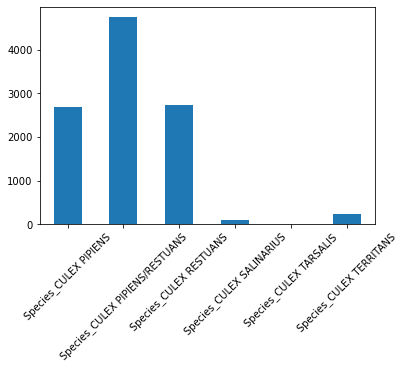

In [107]:
species_caught = df.loc[:,'Species_CULEX PIPIENS':'Species_CULEX TERRITANS'].sum()
species_caught.plot.bar(x=species_caught.index,y=species_caught.values,rot=45)

In [108]:
virus = df[df['WnvPresent'] == 1]
no_virus = df[df['WnvPresent'] == 0]

<AxesSubplot:>

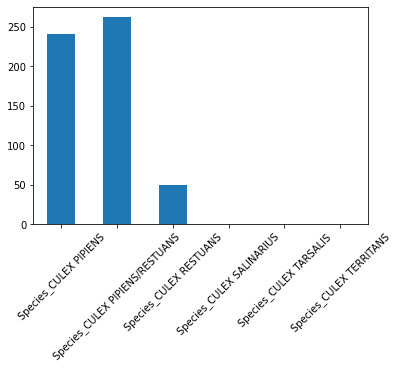

In [109]:
species_count = virus.loc[:,'Species_CULEX PIPIENS':'Species_CULEX TERRITANS'].sum()
species_count.plot.bar(x=species_count.index,y=species_count.values,rot=45)

We will drop the species columns that do not contain any instances of the virus.

In [110]:
df = df.drop(['Species_CULEX SALINARIUS','Species_CULEX TARSALIS','Species_CULEX TERRITANS'],axis=1)

Text(0, 0.5, 'Number of Infected Mosquitos')

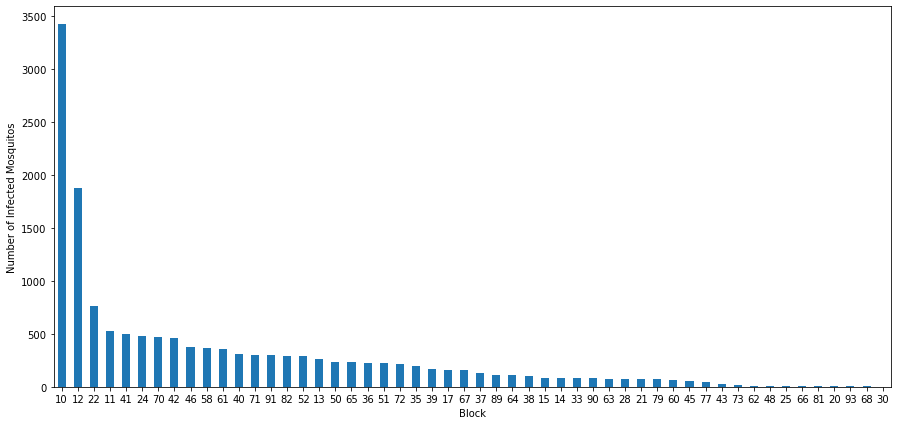

In [94]:
block_group = virus.groupby('Block').sum()
block_count = block_group['NumMosquitos'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,7))
block_count.plot.bar(block_count.index,block_count.values, rot=0)
plt.xlabel('Block')
plt.ylabel('Number of Infected Mosquitos')

Here we can clearly see block 10 has a significant percntage of all virus carrying mosquitos. Block 12 also makes up a considerable amount of the infected mosquitos.

In [424]:
num_block_10 = block_count.loc[10]
num_all = block_count.sum()
percent_block_10 = round(num_block_10/num_all *100,2)
print(f'{percent_block_10}% of infected mosquitos came from block 10')

23.57% of infected mosquitos came from block 10


In [425]:
num_block_12 = block_count.loc[12]
num_all = block_count.sum()
percent_block_12 = round(num_block_12/num_all *100,2)
print(f'{percent_block_12}% of infected mosquitos came from block 12')

12.93% of infected mosquitos came from block 12


In [438]:
print(f'{round((num_block_10 + num_block_12)/num_all*100,2)}% of infected mosquitos came from block 10 and 12.')

36.5% of infected mosquitos came from block 10 and 12.


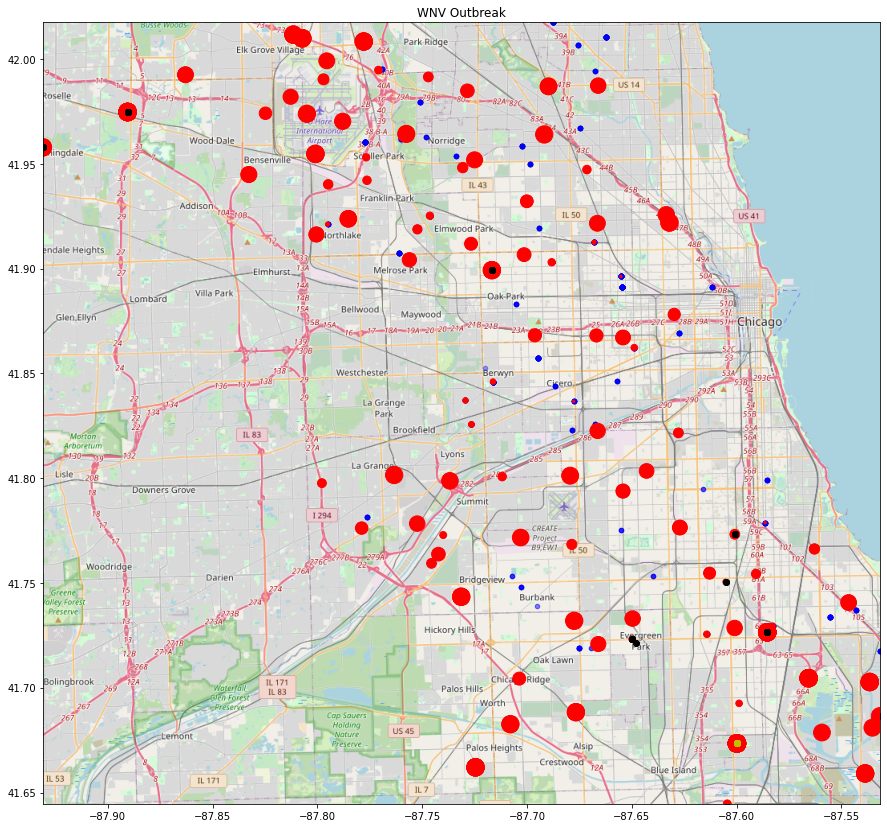

In [118]:
bbox = (df.Longitude.min(),  df.Longitude.max(),  df.Latitude.min(), df.Latitude.max())
mymap = plt.imread('/Users/Dreamscape/OneDrive - Springboard/Capstone 2/map.png')

fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 0.2, c='b', s=20)
ax.scatter(virus.Longitude, virus.Latitude, zorder=1, alpha= 1, c='r', s=virus['NumMosquitos']*6)

ax.scatter(virus[virus.Block==10]['Longitude'],virus[virus.Block==10]['Latitude'],c='black')
ax.scatter(virus[virus.Block==12]['Longitude'],virus[virus.Block==12]['Latitude'],c='y')


ax.set_title('WNV Outbreak')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(mymap, zorder=0, extent = bbox, aspect= 'equal')

- Above latitude and longitude analysis shows that the virus was detected fairly evenly across the city with only a few traps highlighted in blue that did not have any west nile virus detected.
- The Block 10 data seems to be incorrect as there are a number of different locations that indicate they are block 10. Perhaps this is why this column had so many more infected mosquitos than the other blocks.

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

In [157]:
print('Average temperature when no virus is present: ' + str(round(no_virus.Tavg.mean(),2)))
print('Average temperature when virus present: ' + str(round(virus.Tavg.mean(),2)))

Average temperature when no virus is present: 73.08
Average temperature when virus present: 75.1


In [159]:
print('Average precipitation when no virus is present: ' + str(round(no_virus.PrecipTotal.mean(),2)))
print('Average precipitation when virus is present: ' + str(round(virus.PrecipTotal.mean(),2)))

Average precipitation when no virus is present: 0.14
Average precipitation when virus is present: 0.17


This quick analysis shows us that when the virus is present hot and wet conditions are more favorable

<AxesSubplot:xlabel='Month'>

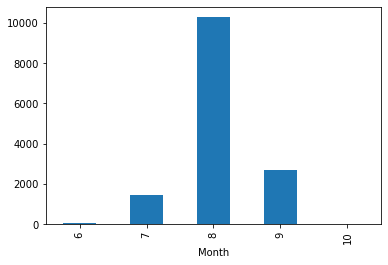

In [294]:
virus_month = virus.groupby('Month')['NumMosquitos'].sum()
virus_month.plot.bar(virus_month.index,virus_month.values)

In [300]:
num_aug = virus_month.loc[8]
total_month = virus_month.sum()
print(f'{round(num_aug / total_month * 100,2)}% of mosquitos with the virus were caught in August.')

70.87% of mosquitos with the virus were caught in August.


In [327]:
# df.groupby(df.index).sum()['WnvPresent'] -- used this as count_virus before

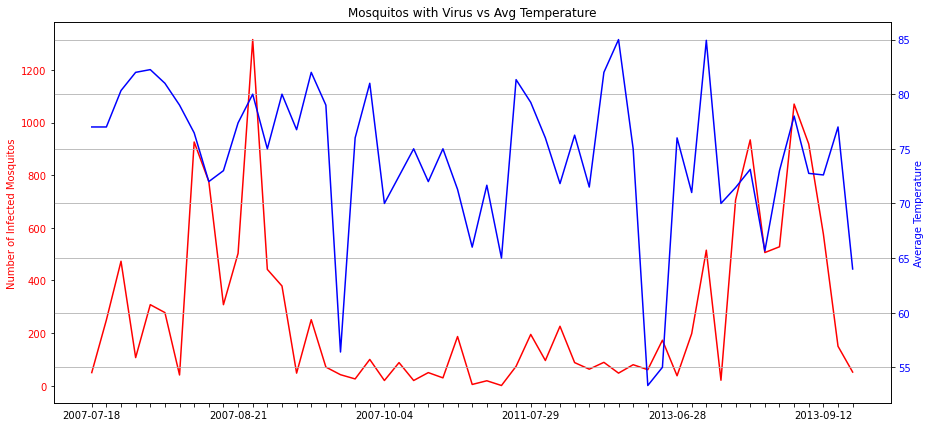

In [360]:
fig, ax1 = plt.subplots(figsize=(15,7))

count_virus = virus.groupby(virus.index).sum()['NumMosquitos']
temp = virus.groupby(virus.index).mean('Tavg')

color='red'
ax1.plot(count_virus.index, count_virus.values,color=color)
ax1.set_ylabel('Number of Infected Mosquitos',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color='blue'
ax2.plot(temp.index,temp.Tavg,color=color)
ax2.set_ylabel('Average Temperature',color=color)
ax2.tick_params(axis='y', labelcolor=color)

every_nth = 10
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.title('Mosquitos with Virus vs Avg Temperature')
plt.grid()

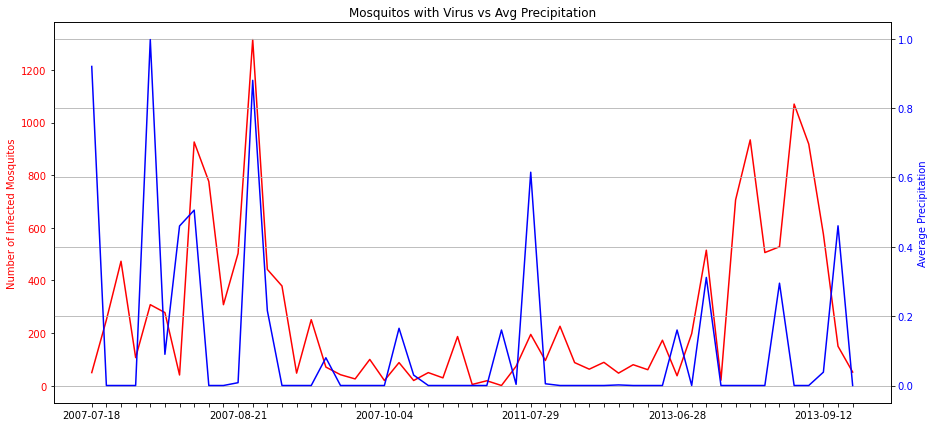

In [361]:
fig, ax1 = plt.subplots(figsize=(15,7))

count_virus = virus.groupby(virus.index).sum()['NumMosquitos']
precip = virus.groupby(virus.index).mean('PrecipTotal')

color='red'
ax1.plot(count_virus.index, count_virus.values,color=color)
ax1.set_ylabel('Number of Infected Mosquitos',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color='blue'
ax2.plot(precip.index,precip.PrecipTotal,color=color)
ax2.set_ylabel('Average Precipitation',color=color)
ax2.tick_params(axis='y', labelcolor=color)


every_nth = 10
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.title('Mosquitos with Virus vs Avg Precipitation')
plt.grid()

In [444]:
odf = df.loc[:,'NumMosquitos':'AvgSpeed']
odf = odf.drop(['Sunrise','Sunset', 'Species_CULEX PIPIENS','Species_CULEX PIPIENS/RESTUANS','Species_CULEX RESTUANS'], axis=1)

<AxesSubplot:>

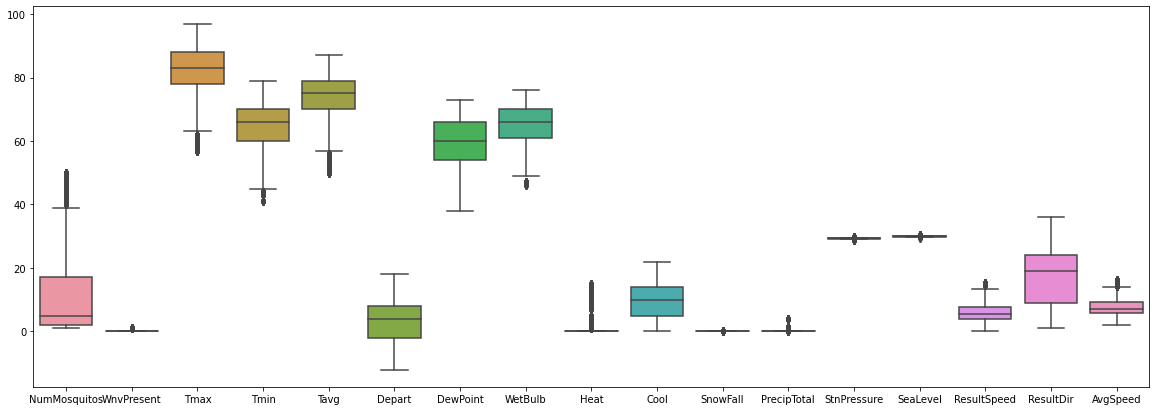

In [400]:
fig,ax = plt.subplots(figsize=(20,7))
sns.boxplot(data=odf)

Here I'm looking at the weather data to ensure there aren't any dramatic outliers. 

<AxesSubplot:>

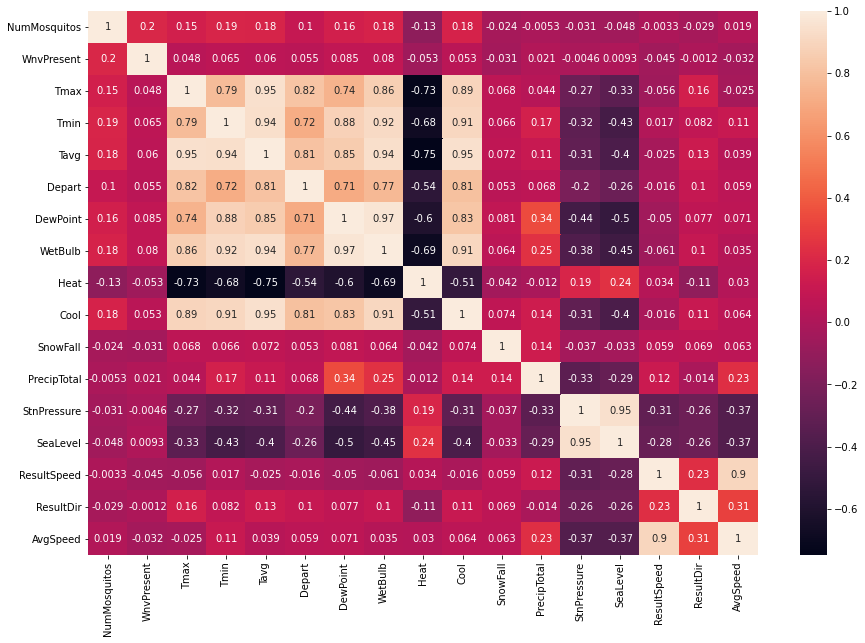

In [479]:
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(odf.corr(),annot=True)

In [468]:
# correlation between features on initial weather dataset
cor = odf.corr().abs()

In [477]:
cor['WnvPresent'].sort_values(ascending=False)

WnvPresent      1.000000
NumMosquitos    0.196820
DewPoint        0.084904
WetBulb         0.079749
Tmin            0.065182
Tavg            0.059881
Depart          0.055436
Heat            0.053497
Cool            0.052920
Tmax            0.047580
ResultSpeed     0.044529
AvgSpeed        0.031869
SnowFall        0.030886
PrecipTotal     0.021284
SeaLevel        0.009346
StnPressure     0.004621
ResultDir       0.001229
Name: WnvPresent, dtype: float64

In [480]:
# correlation between features on full final dataset
fcor = df.corr().abs()

In [482]:
fcor['WnvPresent'].sort_values(ascending=False).head(10)

WnvPresent       1.000000
NumMosquitos     0.196820
DewPoint_lag2    0.115012
Sunrise          0.105227
WetBulb_lag2     0.104167
Sunrise_lag2     0.101017
Month            0.100143
Sunrise_lag8     0.098961
Sunrise_lag4     0.098879
Sunrise_lag6     0.098401
Name: WnvPresent, dtype: float64

# Insights 

#### From out initial exploratory analysis we've identified:
- The only species to carry West Nile Virus in the dataset are Culex Pipiens and Culex Restuans.
- August contains over 70% of all West Nile Virus carrying mosquitos.
- Block 10 and 12 are where 36.5% of all infections were concentrated. 

#### Based on these findings here are a few actionable items:
- Spraying should start in late July and go through August. If there is a particular spray that better kills off the Culex Pipiens and Culex Restuans species this spray should be used.
- Block 10 and 12 should be target locations for extra intervention, both through extra spraying and educating the reseidents in that area on how they can stay safe. Perhaps suggesting they wear bug spray for all of the Summer months. 

# Remove Features with High Correlation

In [67]:
x = df.drop(['WnvPresent'],axis=1)
y = df['WnvPresent']

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=2)

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(x_train)

Iteration # 1


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tmax with VIF of inf
Iteration # 2


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tavg with VIF of inf
Iteration # 3


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tmax_lag2 with VIF of inf
Iteration # 4


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tavg_lag2 with VIF of inf
Iteration # 5


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tmax_lag4 with VIF of inf
Iteration # 6


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tmax_lag6 with VIF of inf
Iteration # 7


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tmax_lag8 with VIF of inf
Iteration # 8


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tavg_lag8 with VIF of inf
Iteration # 9


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tmax_lag10 with VIF of inf
Iteration # 10


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Removing Tavg_lag10 with VIF of 35441966.098221
Iteration # 11


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag2 with VIF of 56538937.890184
Iteration # 12


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel with VIF of 52507317.938377
Iteration # 13


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag6 with VIF of 43250114.907693
Iteration # 14


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise_lag4 with VIF of 35331594.980723
Iteration # 15


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag4 with VIF of 32058473.785248
Iteration # 16


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag10 with VIF of 22104576.301546
Iteration # 17


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise_lag10 with VIF of 20535609.502059
Iteration # 18


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag8 with VIF of 18071099.874278
Iteration # 19


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset_lag2 with VIF of 5703189.584223
Iteration # 20


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Year with VIF of 3683214.486052
Iteration # 21


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag4 with VIF of 3601780.619981
Iteration # 22


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag8 with VIF of 3069715.906764
Iteration # 23


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset_lag8 with VIF of 2426291.377305
Iteration # 24


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag2 with VIF of 2071370.318197
Iteration # 25


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Longitude with VIF of 1678757.737634
Iteration # 26


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset_lag6 with VIF of 1624663.242937
Iteration # 27


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure_lag6 with VIF of 918820.510171
Iteration # 28


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tavg_lag4 with VIF of 728346.861423
Iteration # 29


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset_lag4 with VIF of 665021.797670
Iteration # 30


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing StnPressure with VIF of 544257.469676
Iteration # 31


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Latitude with VIF of 394257.552841
Iteration # 32


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing SeaLevel_lag10 with VIF of 361954.824422
Iteration # 33


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag2 with VIF of 333132.337977
Iteration # 34


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tavg_lag6 with VIF of 298578.587892
Iteration # 35


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset_lag10 with VIF of 269135.162319
Iteration # 36


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag10 with VIF of 253427.078342
Iteration # 37


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise_lag2 with VIF of 207840.616092
Iteration # 38


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin with VIF of 198424.564700
Iteration # 39


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag8 with VIF of 150247.317583
Iteration # 40


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise_lag6 with VIF of 95393.203798
Iteration # 41


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag2 with VIF of 80719.403447
Iteration # 42


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag10 with VIF of 55925.892688
Iteration # 43


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag4 with VIF of 54469.279163
Iteration # 44


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag8 with VIF of 29033.521402
Iteration # 45


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag4 with VIF of 27554.429533
Iteration # 46


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb with VIF of 25227.299987
Iteration # 47


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise_lag8 with VIF of 22242.342716
Iteration # 48


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Tmin_lag6 with VIF of 19680.750021
Iteration # 49


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing WetBulb_lag6 with VIF of 9383.343133
Iteration # 50


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunrise with VIF of 6274.551618
Iteration # 51


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag6 with VIF of 3100.521742
Iteration # 52


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Sunset with VIF of 2872.385313
Iteration # 53


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag10 with VIF of 2414.418301
Iteration # 54


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag2 with VIF of 1935.696238
Iteration # 55


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint with VIF of 1597.492958
Iteration # 56


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag4 with VIF of 1093.130836
Iteration # 57


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing DewPoint_lag8 with VIF of 791.983911
Iteration # 58


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed with VIF of 485.475984
Iteration # 59


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag4 with VIF of 413.428043
Iteration # 60


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool with VIF of 356.527304
Iteration # 61


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag6 with VIF of 340.272618
Iteration # 62


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag4 with VIF of 182.788427
Iteration # 63


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag10 with VIF of 179.454328
Iteration # 64


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag10 with VIF of 173.420571
Iteration # 65


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag2 with VIF of 154.598970
Iteration # 66


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AvgSpeed_lag8 with VIF of 140.254351
Iteration # 67


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Month with VIF of 135.570937
Iteration # 68


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag6 with VIF of 104.919539
Iteration # 69


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag2 with VIF of 80.975547
Iteration # 70


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange_lag8 with VIF of 77.238078
Iteration # 71


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange_lag2 with VIF of 70.149549
Iteration # 72


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Thunderstorm_lag8 with VIF of 69.320906
Iteration # 73


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange_lag6 with VIF of 63.474916
Iteration # 74


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange with VIF of 44.025478
Iteration # 75


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange_lag10 with VIF of 41.967025
Iteration # 76


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing AddressAccuracy with VIF of 33.934723
Iteration # 77


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing TSRA_lag6 with VIF of 28.441937
Iteration # 78


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Trange_lag4 with VIF of 27.707908
Iteration # 79


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Cool_lag8 with VIF of 27.042710
Iteration # 80


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Thunderstorm with VIF of 18.797613
Iteration # 81


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Depart_lag2 with VIF of 18.145780
Iteration # 82


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Thunderstorm_lag4 with VIF of 17.656053
Iteration # 83


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag4 with VIF of 15.901150
Iteration # 84


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag4 with VIF of 13.535498
Iteration # 85


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Depart_lag8 with VIF of 13.093694
Iteration # 86


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing TSRA_lag2 with VIF of 12.040801
Iteration # 87


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Species_CULEX PIPIENS/RESTUANS with VIF of 11.683819
Iteration # 88


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir with VIF of 10.858572
Iteration # 89


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag2 with VIF of 10.108981
Iteration # 90


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag6 with VIF of 9.446394
Iteration # 91


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Heat_lag2 with VIF of 8.687180
Iteration # 92


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Thunderstorm_lag10 with VIF of 8.608760
Iteration # 93


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed with VIF of 8.216161
Iteration # 94


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultSpeed_lag8 with VIF of 7.748345
Iteration # 95


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag2 with VIF of 7.031090
Iteration # 96


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Mist_lag8 with VIF of 6.980117
Iteration # 97


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Rain_lag2 with VIF of 6.950179
Iteration # 98


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag6 with VIF of 6.348813
Iteration # 99


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing ResultDir_lag8 with VIF of 6.124579
Iteration # 100


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Heat_lag6 with VIF of 5.782509
Iteration # 101


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing Day with VIF of 5.519036
Iteration # 102


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Removing PrecipTotal_lag2 with VIF of 5.092117
Iteration # 103


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Complete


In [70]:
x_train = final_df

In [75]:
x_test = x_test[x_train.columns]

# Model Selection

### Null Accuracy

In [76]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

In [77]:
# We can see the class distribution is very uneven. Accuracy will not be a sufficient metric for model selection.
y.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [78]:
# Here we can see if we were to choose 0 for all predictions we would have a 94.7% accuracy.
print('Null Accuracy: '+ str(1-y.mean()))

Null Accuracy: 0.9475537787930707


### KNN

#### Improving default parameters

In [79]:
k_range = range(40,50)
weight_options = ['uniform', 'distance']
knn = KNeighborsClassifier()

param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [80]:
grid = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_iter=20)

In [81]:
grid.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'n_neighbors': range(40, 50),
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [82]:
print(grid.best_score_)
print(grid.best_params_)

0.947168337013759
{'weights': 'uniform', 'n_neighbors': 40}


#### Fitting model with found parameters

In [83]:
best_n = grid.best_params_['n_neighbors']
best_w = grid.best_params_['weights']

knn = KNeighborsClassifier(n_neighbors=best_n,weights=best_w)
knn.fit(x_train,y_train)

knn_y_pred = knn.predict(x_test)
predictions = [round(value) for value in knn_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.91%


#### Understanding Variable Importance

In [84]:
import shap
# shap doesn't support KNN model

# shap_values = shap.TreeExplainer(logreg).shap_values(x_train)
# shap.summary_plot(shap_values, x_train, plot_type="bar")

### Logistic Regression

In [85]:
logreg=LogisticRegression(solver='liblinear')
logreg.fit(x_train,y_train)

log_y_pred = logreg.predict(x_test)
predictions = [round(value) for value in log_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.86%


In [86]:
# shap_values = shap.TreeExplainer(logreg).shap_values(x_train)
# shap.summary_plot(shap_values, x_train, plot_type="bar")

### XGB

In [87]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

xgb_y_pred = xgb.predict(x_test)
predictions = [round(value) for value in xgb_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.67%


In [88]:
# Link to workaround for XGB and Shap 
# https://github.com/slundberg/shap/issues/1215

In [89]:
mybooster = xgb.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


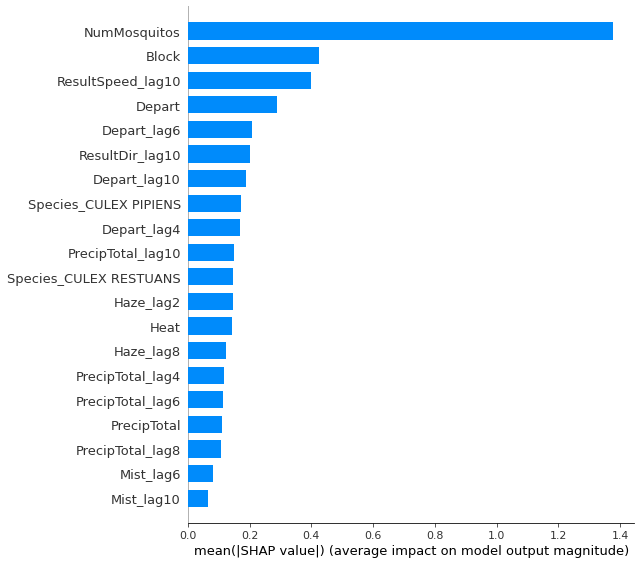

In [90]:
shap_values = shap_ex.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

### Random Forrest

In [91]:
randf = RandomForestClassifier(n_estimators=20, random_state=0)
randf.fit(x_train,y_train)

randf_y_pred = randf.predict(x_test)
predictions = [round(value) for value in randf_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 94.58%


#### Using Shap to understand variable importance in RandomForrest model

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


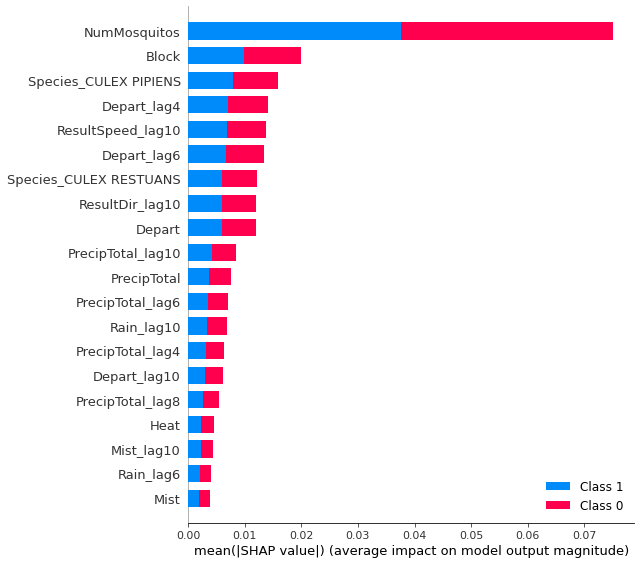

In [92]:
shap_values = shap.TreeExplainer(randf).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

# Comparing Models with AUC / ROC curve

In [93]:
base_prob = [0 for _ in range(len(y_test))]
knn_prob = knn.predict_proba(x_test)[:,1]
log_prob = logreg.predict_proba(x_test)[:,1]
xgb_prob = xgb.predict_proba(x_test)[:,1]
randf_prob = randf.predict_proba(x_test)[:,1]

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve

In [95]:
base_auc = roc_auc_score(y_test,base_prob)
knn_auc = roc_auc_score(y_test,knn_prob)
log_auc = roc_auc_score(y_test,log_prob)
xgb_auc = roc_auc_score(y_test,xgb_prob)
randf_auc = roc_auc_score(y_test,randf_prob)

In [96]:
print('Base AUC = %.4f'%(base_auc))
print('KNeighborClassifier AUC = %.4f'%(knn_auc))
print('Logistic Regression AUC = %.4f'%(log_auc))
print('XGBoost AUC = %.4f'%(xgb_auc))
print('RandomForest AUC = %.4f'%(knn_auc))

Base AUC = 0.5000
KNeighborClassifier AUC = 0.8157
Logistic Regression AUC = 0.8618
XGBoost AUC = 0.8722
RandomForest AUC = 0.8157


In [97]:
base_fpr, base_tpr, _ = roc_curve(y_test,base_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test,knn_prob)
log_fpr, log_tpr, _ = roc_curve(y_test,log_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test,xgb_prob)
randf_fpr, randf_tpr, _ = roc_curve(y_test,randf_prob)

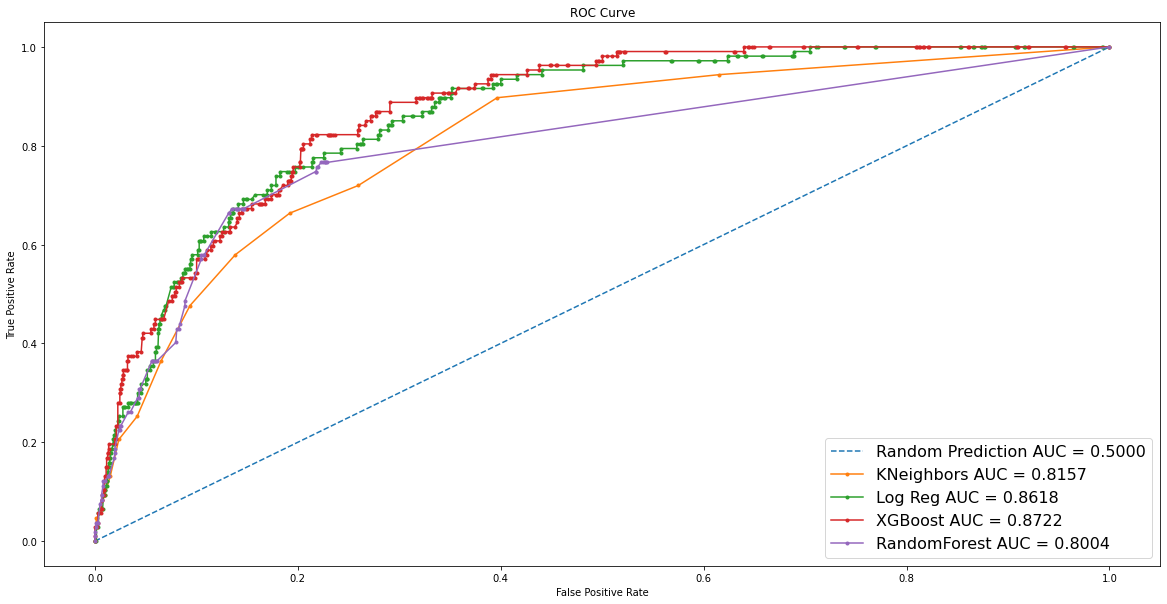

In [98]:
plt.subplots(figsize=(20,10))

plt.plot(base_fpr, base_tpr, linestyle='--', label='Random Prediction AUC = %.4f'% base_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNeighbors AUC = %.4f'% knn_auc)
plt.plot(log_fpr, log_tpr, marker='.', label='Log Reg AUC = %.4f'% log_auc)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost AUC = %.4f'% xgb_auc)
plt.plot(randf_fpr, randf_tpr, marker='.', label='RandomForest AUC = %.4f'% randf_auc)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(prop={'size': 16})

# Precision-Recall Curve

- Better for datasets with a large class imbalance because it avoids using true negatives in the calculation (0s)

In [99]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

KNN: f1=0.000 auc=0.230
Log: f1=0.000 auc=0.245
XGB: f1=0.200 auc=0.286
RandF: f1=0.186 auc=0.251


Text(0.5, 1.0, 'Precision Curve')

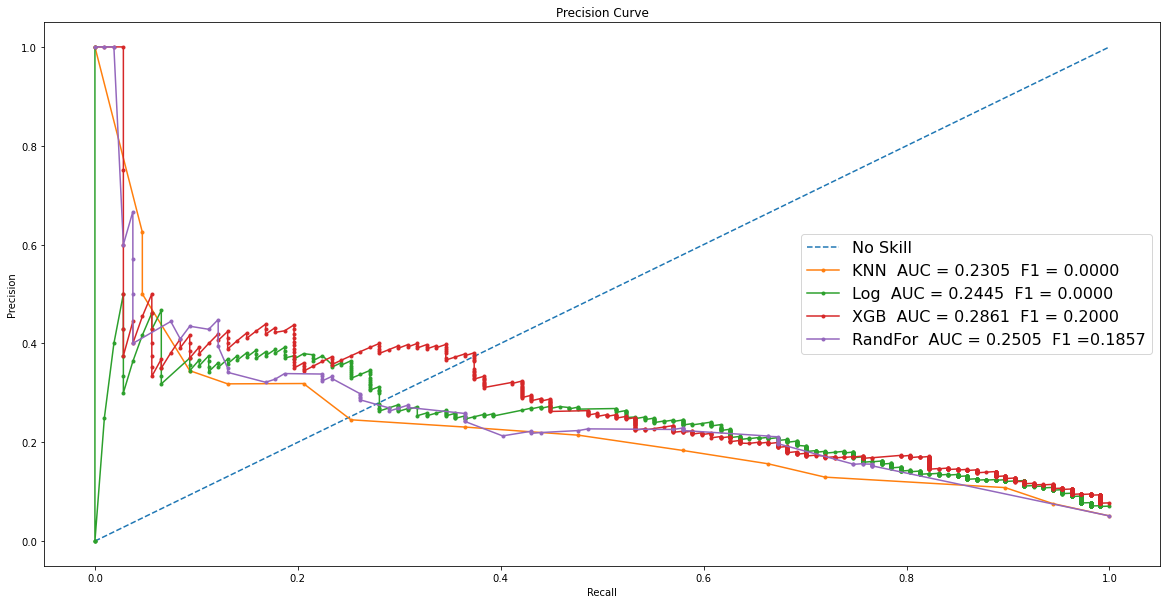

In [100]:
plt.subplots(figsize=(20,10))

knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_prob)
log_precision, log_recall, _ = precision_recall_curve(y_test, log_prob)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_prob)
randf_precision, randf_recall, _ = precision_recall_curve(y_test, randf_prob)

knn_f1, knn_auc = f1_score(y_test, knn_y_pred), auc(knn_recall, knn_precision)
log_f1, log_auc = f1_score(y_test, log_y_pred), auc(log_recall, log_precision)
xgb_f1, xgb_auc = f1_score(y_test, xgb_y_pred), auc(xgb_recall, xgb_precision)
randf_f1, randf_auc = f1_score(y_test, randf_y_pred), auc(randf_recall, randf_precision)

print('KNN: f1=%.3f auc=%.3f' % (knn_f1, knn_auc))
print('Log: f1=%.3f auc=%.3f' % (log_f1, log_auc))
print('XGB: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
print('RandF: f1=%.3f auc=%.3f' % (randf_f1, randf_auc))


plt.plot(base_fpr, base_tpr, linestyle='--', label='No Skill')
plt.plot(knn_recall, knn_precision, marker='.', label='KNN  AUC = %.4f  F1 = %.4f'% (knn_auc, knn_f1))
plt.plot(log_recall, log_precision, marker='.', label='Log  AUC = %.4f  F1 = %.4f'% (log_auc, log_f1))
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB  AUC = %.4f  F1 = %.4f'% (xgb_auc, xgb_f1))
plt.plot(randf_recall, randf_precision, marker='.', label='RandFor  AUC = %.4f  F1 =%.4f' % (randf_auc, randf_f1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(prop={'size': 16})
plt.title('Precision Curve')

#### Based on the AUC score and F1 score from the precision curve we can determine the XGB model to be the best choice for this problem.

# Confusion Matrix

In [101]:
from sklearn.metrics import confusion_matrix

In [102]:
conf_mat = confusion_matrix(y_test, xgb_y_pred)
print(conf_mat)

[[1976   19]
 [  93   14]]


In [103]:
TN = conf_mat[0,0]
TP = conf_mat[1,1]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

- Accuracy = TP + TN / TN + TP + FP + FN
- Precision / Positive Predictive Value = TP / TP + FP
- Sensativity / Recall / True Positive Rate = TP / TP + FN
- Specificity / True Negative Rate = TN / TN + FP

#### XGBoost

In [112]:
# Accuracy
from sklearn.metrics import accuracy_score
print(f'Accuracy score = {round(accuracy_score(y_test, xgb_y_pred),4)}')

# Recall
from sklearn.metrics import recall_score
print(f'Recall = {round(recall_score(y_test, xgb_y_pred, average=None)[0],4)}')

# Precision
from sklearn.metrics import precision_score
print(f'Precision score = {round(precision_score(y_test, xgb_y_pred, average=None)[0],4)}')

# F1
from sklearn.metrics import f1_score
print(f'F1 Score = {round(f1_score(y_test, xgb_y_pred, average=None)[1],4)}')


Accuracy score = 0.9467
Recall = 0.9905
Precision score = 0.9551
F1 Score = 0.2


#### Random Forrest

In [105]:
print(f'Accuracy score = {accuracy_score(y_test, randf_y_pred)}')
print(f'Recall = {recall_score(y_test, randf_y_pred, average=None)}')
print(f'Precision score = {precision_score(y_test, randf_y_pred, average=None)}')
print(f'F1 Score = {f1_score(y_test, randf_y_pred, average=None)}')

Accuracy score = 0.9457659372026641
Recall = [0.98997494 0.12149533]
Precision score = [0.95456742 0.39393939]
F1 Score = [0.97194882 0.18571429]


# Tuning Model

Minimize False Negatives. - Predict no event when in fact there was an event.
A few False Positives are ok. - Predict an event when there was no event.

In [106]:
# Randomizedsearchcv and Gridsearchcv to improve parameters
# Remove all rows that have the species that are not seen in infected. 

# X AUC curve, ROC curve, Confusion Matrix to assess model success

# X  XGBoost algorithim - most winning algorithm

# X  RandomForrest algorithim - another good one to try

# X  Haversign distance - find distance using lat and long

# X  Merge df's on date

# X Make multiple lag columns for weather. Up to 21 days. Many new columns.  

# X What features are important. (look at link,python library to help)  

# X Find if columns are highly correlated and remove one of them. (another package to help) 

In [114]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [115]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [116]:
grid = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [117]:
grid.fit(x_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   53.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 15.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 27.0min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 34.9min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [118]:
print(grid.best_score_)
print(grid.best_params_)

0.8482676323536877
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 180}


In [121]:
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 180}

In [403]:
xgb = XGBClassifier(learning_rate=0.1,max_depth=3,n_estimators=180)
xgb.fit(x_train,y_train)

xgb_y_pred = xgb.predict(x_test)